# Emotion Analysis in Tweets 
by Jesse Elliott and Alina Gonzalez

#### Our data 
For this project we utilized [this](https://github.com/dair-ai/emotion_dataset) dataset with sampled tweets + preprocessed emotions as labels. 

__The labels were as provided:__
Anger : 0
Fear : 1
Joy : 2
Love : 3
Sadness : 4
Surprise : 5

### All imports & Constants

In [18]:
import pandas as pd
import numpy as np 
from collections import Counter 
import math 
import random 
import time 
from utils import LanguageModel 
from tqdm.notebook import tqdm 
import json

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pickle

SENTENCE_BEGIN = "<s>"
SENTENCE_END = "</s>"
UNK = "<UNK>"
EMOTION_KEY = {0: 'anger', 1: 'fear', 2: 'joy', 3:'love', 4:'sadness', 5: 'surprise'} # manually done 

### Initial Analysis

In [19]:
df = pd.read_csv('data/training.csv')
df['label_text'] = [EMOTION_KEY[_] for _ in df['label']]
df.head()

,text,label,label_text
0,i didnt feel humiliated,0,anger
1,i can go from feeling so hopeless to so damned...,0,anger
2,im grabbing a minute to post i feel greedy wrong,3,love
3,i am ever feeling nostalgic about the fireplac...,2,joy
4,i am feeling grouchy,3,love


In [20]:
# write the data frame to .txt file 
path = 'data/training.txt'

with open(path, 'w') as file: 
    for line in list(df['text']): 
        file.write(line + '\n')

In [21]:
px.histogram(df["label_text"]) # everyone is afraid i guess

##### Balancing the data

We came to the conclusion that we needed to balance the data in order to prevent our model from underperforming with certain emotions. 

In [22]:
# Determine the number of data points for the 'fear' class
fear_count = df[df['label'] == 1].shape[0]

# Get the data points for each emotion class with the same count as 'fear'
balanced_data = pd.concat([df[df['label'] == label].sample(fear_count, replace=True, random_state=42) 
                           for label in range(6)])

# Save the balanced data to a new CSV file
balanced_data.to_csv('data/balanced_data.csv', index=False)

In [23]:
# write the data frame to .txt file 
path = 'data/balanced_training.txt'

with open(path, 'w') as file: 
    for line in list(balanced_data['text']): 
        file.write(line + '\n')

In [24]:
px.histogram(balanced_data["label_text"]) # thats better

##### Exploring the data! 

We want to understand what words define an emotion! Lets make a word cloud to get a visual representation of just that! 

In [25]:
def parse(lst:list, stopwords):
    """ parses a list of strings representing tweets """ 
    valid_total = []
    for tweet in lst: 
        tweet = tweet.split()
        valid = [word for word in tweet if word not in stopwords]
        valid_total.append(" ".join(valid))
    return " ".join(valid_total)

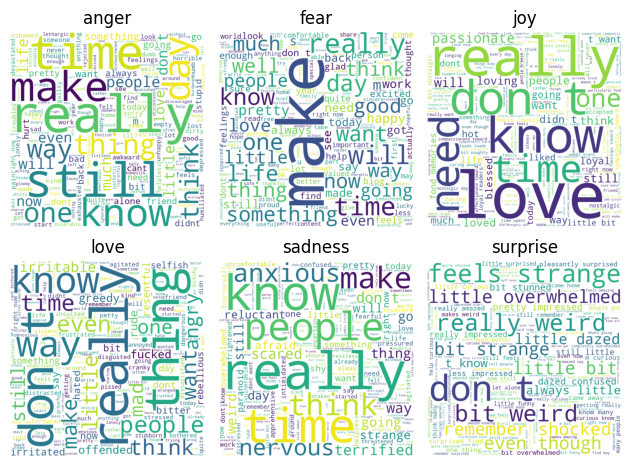

In [26]:
stopwords = set(list(STOPWORDS) + ['feel', 'feeling', 'ive', 'im'])

# generate a word cloud for every... label
for label in EMOTION_KEY.keys(): 
    sub_df = balanced_data.loc[balanced_data['label'] == label] # gets only values with this specific label 
    text = parse(sub_df['text'].tolist(), stopwords)
    wc = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(text)
    # plot the WordCloud image  
    plt.subplot(2, 3, label+1)     
    plt.title(EMOTION_KEY[label])                
    # plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wc)
    plt.axis("off")
    plt.tight_layout(pad = 1)
    
plt.show()

### Model Training and Evaluation 

In [27]:
train = pd.read_csv('data/balanced_data.csv')
test = pd.read_csv('data/test.csv')
valid = pd.read_csv('data/validation.csv')

EMOTION_KEY = {0: 'anger', 1: 'fear', 2: 'joy', 3:'love', 4:'sadness', 5: 'surprise'}
train['label_text'] = train['label'].map(EMOTION_KEY)
test['label_text'] = test['label'].map(EMOTION_KEY)
valid['label_text'] = valid['label'].map(EMOTION_KEY)

In [28]:
# tokenize text into sequences
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train['text'])
train_sequences = tokenizer.texts_to_sequences(train['text'])
test_sequences = tokenizer.texts_to_sequences(test['text'])
valid_sequences = tokenizer.texts_to_sequences(valid['text'])

In [29]:
# pad the text sequences
max_length = max([len(seq) for seq in train_sequences])
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding='post')

#### Models: 

In [30]:

# a simple feed-forward neural network using sequential dense layers
def simple_ffn(input_shape, output_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dense(output_shape, activation='softmax')
    ])
    return model

# a recurrent neural network model
def rnn_model(input_shape, output_shape):
    model = Sequential([
        Embedding(input_dim=10000, output_dim=64, input_length=input_shape),
        LSTM(64),
        Dense(output_shape, activation='softmax')
    ])
    return model

# a convolutional neural network model
def cnn_model(input_shape, output_shape):
    model = Sequential([
        Embedding(input_dim=10000, output_dim=64, input_length=input_shape),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(output_shape, activation='softmax')
    ])
    return model

#### Training: 

In [31]:
# func to train the model and output evaluation of training based on the history
def train_and_evaluate(model, train_data, train_labels, valid_data, valid_labels, test_data, test_labels):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_data, train_labels, epochs=10, validation_data=(valid_data, valid_labels), verbose=2)
    loss, accuracy = model.evaluate(test_data, test_labels, verbose=2)
    return history, loss, accuracy

In [32]:
X_train, y_train = train_padded, train['label'].values
X_test, y_test = test_padded, test['label'].values
X_valid, y_valid = valid_padded, valid['label'].values

In [33]:
input_shape = X_train.shape[1:]
output_shape = len(train['label'].unique())
ffn_model = simple_ffn(input_shape, output_shape)
ffn_history, ffn_loss, ffn_accuracy = train_and_evaluate(ffn_model, X_train, y_train, X_valid, y_valid, X_test, y_test)

Epoch 1/10


c:\Users\alina\anaconda3\envs\ds\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1006/1006 - 1s - 1ms/step - accuracy: 0.1921 - loss: 149.6174 - val_accuracy: 0.2140 - val_loss: 61.7090
Epoch 2/10
1006/1006 - 1s - 811us/step - accuracy: 0.2231 - loss: 39.4017 - val_accuracy: 0.1595 - val_loss: 30.6883
Epoch 3/10
1006/1006 - 1s - 786us/step - accuracy: 0.2401 - loss: 18.0662 - val_accuracy: 0.2105 - val_loss: 15.5865
Epoch 4/10
1006/1006 - 1s - 774us/step - accuracy: 0.2411 - loss: 10.7706 - val_accuracy: 0.2385 - val_loss: 9.3560
Epoch 5/10
1006/1006 - 1s - 724us/step - accuracy: 0.2486 - loss: 7.0126 - val_accuracy: 0.1325 - val_loss: 9.3794
Epoch 6/10
1006/1006 - 1s - 717us/step - accuracy: 0.2461 - loss: 5.3496 - val_accuracy: 0.1235 - val_loss: 6.3832
Epoch 7/10
1006/1006 - 1s - 717us/step - accuracy: 0.2517 - loss: 4.1898 - val_accuracy: 0.2165 - val_loss: 5.3214
Epoch 8/10
1006/1006 - 1s - 758us/step - accuracy: 0.2428 - loss: 3.3734 - val_accuracy: 0.1230 - val_loss: 3.7176
Epoch 9/10
1006/1006 - 1s - 820us/step - accuracy: 0.2415 - loss: 2.5880 - val_accura

In [34]:
rnn_input_shape = X_train.shape[1]
rnn_model = rnn_model(rnn_input_shape, output_shape)
rnn_history, rnn_loss, rnn_accuracy = train_and_evaluate(rnn_model, X_train, y_train, X_valid, y_valid, X_test, y_test)

ValueError: Unrecognized keyword arguments passed to Embedding: {'input_length': 66}

In [ ]:
cnn_model = cnn_model(rnn_input_shape, output_shape)
cnn_history, cnn_loss, cnn_accuracy = train_and_evaluate(cnn_model, X_train, y_train, X_valid, y_valid, X_test, y_test)

In [ ]:
print("Simple Feedforward Neural Network - Test Loss:", ffn_loss, "Test Accuracy:", ffn_accuracy)
print("RNN Model - Test Loss:", rnn_loss, "Test Accuracy:", rnn_accuracy)
print("CNN Model - Test Loss:", cnn_loss, "Test Accuracy:", cnn_accuracy)


#### Visualization: 

In [ ]:
def plot_history(history, model_name):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.title(model_name)
    plt.legend(loc='lower right')

In [ ]:
plot_history(ffn_history, 'Simple Feed-Forward')

In [ ]:
plot_history(rnn_history, 'Recurrent')

In [ ]:
plot_history(cnn_history, 'Convolutional')

In [ ]:
ffn_model.save('saved_models/ffn_model.h5')
rnn_model.save('saved_models/rnn_model.h5')
cnn_model.save('saved_models/cnn_model.h5')

# save the tokenizer
with open('saved_models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Vanilla Bi-gram Model
We want to explore how the different neural networks and different emotions compare ot a simple vanilla bigram model. 

##### Util funcs: 

In [ ]:
def create_ngrams(tokens: list, n: int) -> list:
  """Creates n-grams for the given token sequence.
  Args:
    tokens (list): a list of tokens as strings
    n (int): the length of n-grams to create

  Returns:
    list: list of tuples of strings, each tuple being one of the individual n-grams
  """
  lst = []
  for i in range(len(tokens)): 
    ngrams = []
    for j in range(i, i+n): 
      try: 
        ngrams.append(tokens[j])
      except: 
        break
    if len(ngrams) == n: 
      lst.append(tuple(ngrams))
  return lst 

In [ ]:
def tokenize_line(line: str, ngram: int, 
                   by_char: bool = True, 
                   sentence_begin: str=SENTENCE_BEGIN, 
                   sentence_end: str=SENTENCE_END):
  """
  Tokenize a single string. Glue on the appropriate number of 
  sentence begin tokens and sentence end tokens (ngram - 1), except
  for the case when ngram == 1, when there will be one sentence begin
  and one sentence end token.
  Args:
    line (str): text to tokenize
    ngram (int): ngram preparation number
    by_char (bool): default value True, if True, tokenize by character, if
      False, tokenize by whitespace
    sentence_begin (str): sentence begin token value
    sentence_end (str): sentence end token value

  Returns:
    list of strings - a single line tokenized
  """
  inner_pieces = None
  if by_char:
    inner_pieces = list(line)
  else:
    # otherwise split on white space
    inner_pieces = line.split()

  if ngram == 1:
    tokens = [sentence_begin] + inner_pieces + [sentence_end]
  else:
    tokens = ([sentence_begin] * (ngram - 1)) + inner_pieces + ([sentence_end] * (ngram - 1))
  # always count the unigrams
  return tokens

In [ ]:
def tokenize(data: list, ngram: int, 
                   by_char: bool = True, 
                   sentence_begin: str=SENTENCE_BEGIN, 
                   sentence_end: str=SENTENCE_END):
  """
  Tokenize each line in a list of strings. Glue on the appropriate number of 
  sentence begin tokens and sentence end tokens (ngram - 1), except
  for the case when ngram == 1, when there will be one sentence begin
  and one sentence end token.
  Args:
    data (list): list of strings to tokenize
    ngram (int): ngram preparation number
    by_char (bool): default value True, if True, tokenize by character, if
      False, tokenize by whitespace
    sentence_begin (str): sentence begin token value
    sentence_end (str): sentence end token value

  Returns:
    list of strings - all lines tokenized as one large list
  """
  total = []
  # also glue on sentence begin and end items
  for line in data:
    line = line.strip()
    # skip empty lines
    if len(line) == 0:
      continue
    tokens = tokenize_line(line, ngram, by_char, sentence_begin, sentence_end)
    total += tokens
  return total

In [ ]:
text = []
with open('data/balanced_training.txt', 'r') as file: 
    for line in file: 
        text.append(line.strip())

##### Training and generating: 

In [ ]:
# reading data
df = pd.read_csv('data/balanced_data.csv')

emotion_dfs = {}
for label in EMOTION_KEY: 
    curr = df.loc[df['label'] == label]
    emotion_dfs[label] = curr
df.head()

In [ ]:
# ngram = 2
# gen_sents = {}
# for label, df_ in tqdm(emotion_dfs.items()): 
#     # tokenize by word
#     toks = tokenize(list(df_['text']), ngram, by_char=False)
#     lm = LanguageModel(ngram)
#     lm.train(toks)
#     gen_sents[label] = lm.generate(1000)

In [ ]:
# with open('vanilla_emotion_results.txt', 'w') as file: 
#     json.dump(gen_sents, file)